<a href="https://colab.research.google.com/github/jj878196/jupyterlab/blob/master/%E3%80%8CHandwriting_recognition_by_ResNet%E3%80%8D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **套件**

In [ ]:
# -*- coding: utf-8 -*-
from sklearn.metrics import f1_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## **測試是否能夠使用GPU**

In [ ]:
# GPU
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('GPU state:', device)

GPU state: cuda:0


## **資料載入**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Cifar10 資料正規化
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((128,128)), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # 這行不動，負責轉換資料成需要的格式
# 資料
batch_size = 10 # 越大越好，但受制於記憶體大小，只能用試的 原50
train_data_path = '/content/drive/MyDrive/我的大數據筆記/Handwriting Recognition/j. fifth dataset/14類(重新打散命名)/train_sign'
test_data_path = '/content/drive/MyDrive/我的大數據筆記/Handwriting Recognition/j. fifth dataset/14類(重新打散命名)/test_sign'
trainset = torchvision.datasets.ImageFolder(root=train_data_path, transform=transform)
testset = torchvision.datasets.ImageFolder(root=test_data_path, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2) # 避免overfiting建議shuffle=True(打亂順序) num_worker決定一次用幾組batch，同樣越大越好(2 or 4)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)

## **宣告class**

In [ ]:
# classes = ('F仲容','F佳欣','F旻家','F明賢','F榮昇','F珮如','others','photos','仲容','佳欣','旻家','明賢','榮昇','珮如',) # 分類的類別
# classes = ('F仲容','F佳欣','F旻家','F明賢','F榮昇','F珮如','others','仲容','佳欣','旻家','明賢','榮昇','珮如',) # 分類的類別
classes = ('others', 'photos','仲容本人','仲容非本人','佳欣本人','佳欣非本人','旻家本人','旻家非本人','明賢本人','明賢非本人','榮昇本人','榮昇非本人','珮如本人','珮如非本人') # 分類的類別
# classes = ('false','true') # 分類的類別
num_classes = len(classes)

# **看看訓練資料裡面的圖片與label是否有錯誤**

## 給人看的

This label is a 佳欣本人
torch.Size([3, 128, 128])


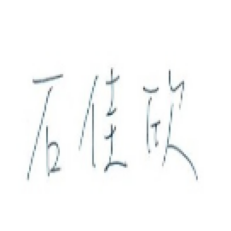

This label is a 仲容非本人
torch.Size([3, 128, 128])


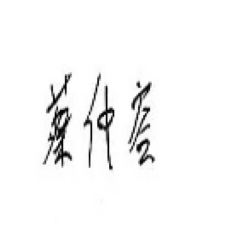

This label is a 佳欣本人
torch.Size([3, 128, 128])


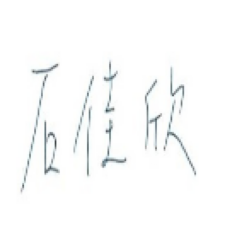

This label is a 榮昇非本人
torch.Size([3, 128, 128])


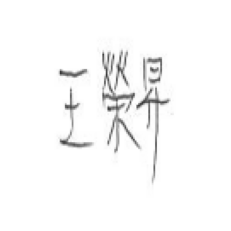

This label is a 仲容非本人
torch.Size([3, 128, 128])


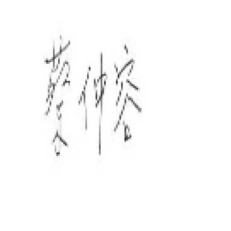

This label is a 榮昇非本人
torch.Size([3, 128, 128])


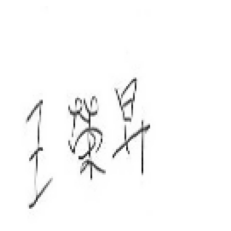

This label is a 旻家非本人
torch.Size([3, 128, 128])


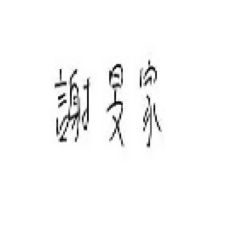

This label is a 榮昇本人
torch.Size([3, 128, 128])


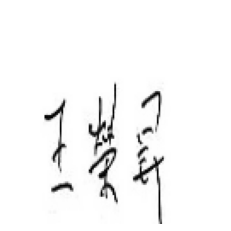

This label is a 旻家非本人
torch.Size([3, 128, 128])


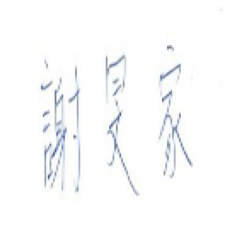

This label is a 珮如非本人
torch.Size([3, 128, 128])


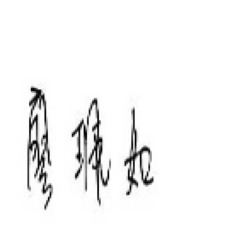

This label is a 榮昇本人
torch.Size([3, 128, 128])


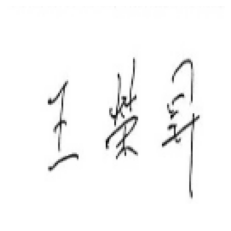

This label is a 佳欣本人
torch.Size([3, 128, 128])


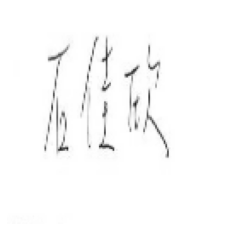

This label is a 明賢非本人
torch.Size([3, 128, 128])


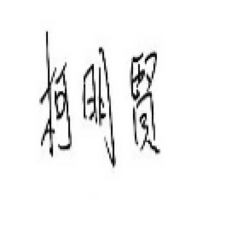

This label is a 旻家非本人
torch.Size([3, 128, 128])


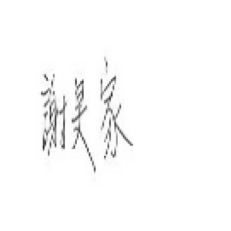

This label is a photos
torch.Size([3, 128, 128])


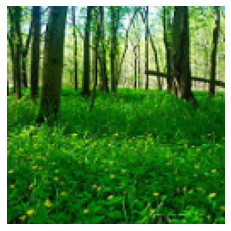

This label is a 仲容非本人
torch.Size([3, 128, 128])


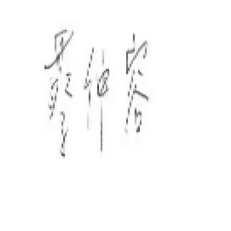

This label is a 仲容非本人
torch.Size([3, 128, 128])


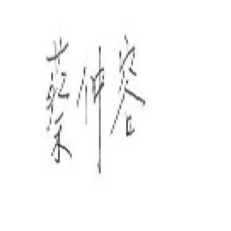

This label is a 佳欣非本人
torch.Size([3, 128, 128])


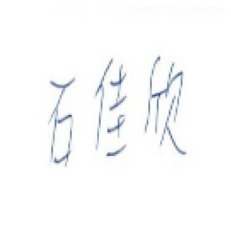

This label is a 旻家本人
torch.Size([3, 128, 128])


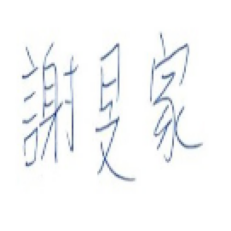

This label is a photos
torch.Size([3, 128, 128])


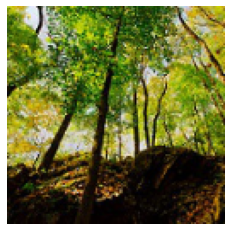

This label is a 旻家本人
torch.Size([3, 128, 128])


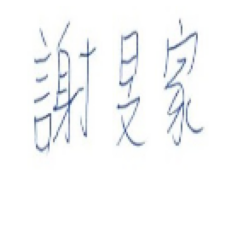

This label is a photos
torch.Size([3, 128, 128])


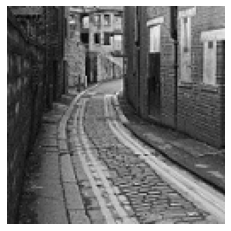

This label is a 珮如非本人
torch.Size([3, 128, 128])


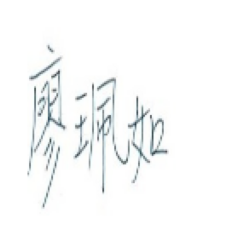

This label is a 仲容本人
torch.Size([3, 128, 128])


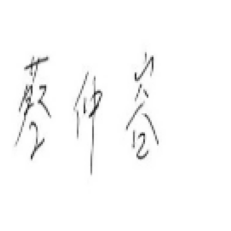

This label is a 旻家非本人
torch.Size([3, 128, 128])


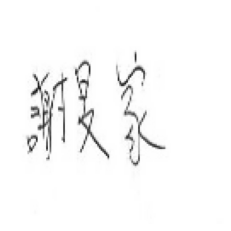

This label is a 旻家非本人
torch.Size([3, 128, 128])


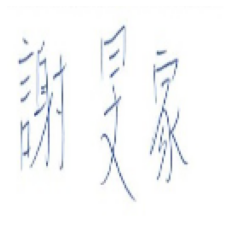

This label is a 明賢非本人
torch.Size([3, 128, 128])


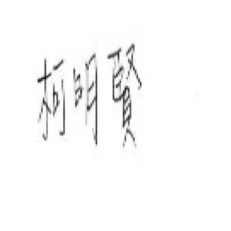

This label is a 佳欣本人
torch.Size([3, 128, 128])


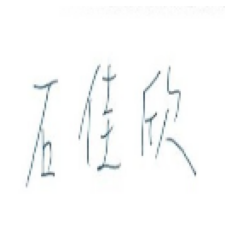

This label is a 仲容本人
torch.Size([3, 128, 128])


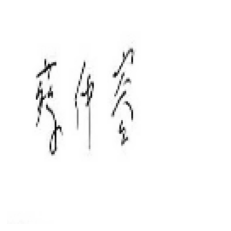

This label is a 佳欣本人
torch.Size([3, 128, 128])


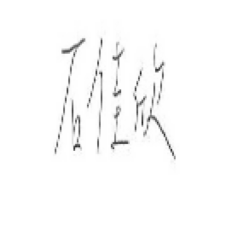

In [ ]:
# 顯示圖像的function
def imshow(img):
    img = img / 2 +0.5
    npimg = img.numpy()
    print(img.shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# 取得圖片與標記資料
dataiter = iter(trainloader)
images, labels = dataiter.next()

for j in range(batch_size): # 原自定次數10，更改為batch_size
  # print label
  print("This label is a " + str(classes[labels[j]]))
  # show images
  imshow(images[j])

## **ResNet18 架構宣告**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):
        super(ResidualBlock, self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(outchannel)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or inchannel != outchannel:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outchannel)
            )

    def forward(self, x):
        out = self.left(x)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, ResidualBlock, num_classes=10):
        super(ResNet, self).__init__()
        self.inchannel = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.layer1 = self.make_layer(ResidualBlock, 64,  2, stride=1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride=2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride=2)
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride=2)
        self.fc = nn.Linear(8192, num_classes) # 原512改8192

    def make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)   #strides=[1,1]
        layers = []
        for stride in strides:
            layers.append(block(self.inchannel, channels, stride))
            self.inchannel = channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


def ResNet18():
    return ResNet(ResidualBlock, num_classes=num_classes)

resnet18 = ResNet18().to(device)

In [ ]:
from torchsummary import summary

model=summary(resnet18, (3, 128, 128))
print(model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,728
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          36,864
       BatchNorm2d-5         [-1, 64, 128, 128]             128
              ReLU-6         [-1, 64, 128, 128]               0
            Conv2d-7         [-1, 64, 128, 128]          36,864
       BatchNorm2d-8         [-1, 64, 128, 128]             128
     ResidualBlock-9         [-1, 64, 128, 128]               0
           Conv2d-10         [-1, 64, 128, 128]          36,864
      BatchNorm2d-11         [-1, 64, 128, 128]             128
             ReLU-12         [-1, 64, 128, 128]               0
           Conv2d-13         [-1, 64, 128, 128]          36,864
      BatchNorm2d-14         [-1, 64, 1

## 宣告最佳化 (Optimization)與損失損函數 (Loss function)

In [ ]:
criterion = nn.CrossEntropyLoss() # loss function 負責表現出模型計算的結果與實際的落差
optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9) # 優化器 負責優化model表現
# lr 學習率  momentum不要改動
# 建議這兩行都不要做更動

## **開始訓練，Training**

In [ ]:
Accuracy_num=[]
loss_num=[]
epoch=10
epoch1=epoch
for epoch in range(epoch): # 訓練epoch數
  running_loss = 0.0 #將total loss 歸零
  for i, data in enumerate(trainloader, 0):  # 依batch_size來調整一次要訓練幾張
    # 取得訓練資料
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    # 將gradients parameter歸零
    optimizer.zero_grad()
    
    # forward + backward + 最佳化(Optimization)
    outputs = resnet18(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    loss_num.append(loss.item())
    # print statistics
    running_loss += loss.item() #把全部的loss加起來，等等會再除
    mini_batch_size = 30 # 每mini_batch_size次就進行測次(不懂設什麼好)
    if i % mini_batch_size == mini_batch_size-1: 
      print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / mini_batch_size))
      class_correct = list(0. for i in range(num_classes))
      class_total = list(0. for i in range(num_classes))
      actuals = []
      predications = []
      running_loss = 0.0 #歸零，不然還會累加
      with torch.no_grad():
        for data in testloader: #原為testloader
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          outputs = resnet18(images)
          
          predication = outputs.argmax(dim = 1,keepdim = True)
          actuals.extend(labels.view_as(predication))
          predications.extend(predication)
            
          _, predicted = torch.max(outputs, 1)
          c = (predicted == labels).squeeze()
          for i in range(batch_size):#因為一次的batch_size是多少就跑幾次
              label = labels[i]
              class_correct[label] += c[i].item()
              class_total[label] += 1
        for i in range(num_classes):
          print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))
        print('Accuracy of All : %2d %%' % (100 * sum(class_correct) / sum(class_total)))
        print("----------------------------------------")
      Accuracy_num.append(100 * sum(class_correct) / sum(class_total))            
PATH = '/content/drive/MyDrive/我的大數據筆記/Handwriting Recognition/j. fifth dataset/14類(重新打散命名)/model/仲容0829.pth'
torch.save(resnet18.state_dict(), PATH)
# 儲存訓練完的model 分幾類下一次就只能是幾類
print('Finished Training')

[1,    30] loss: 2.167
Accuracy of others : 96 %
Accuracy of photos : 96 %
Accuracy of  仲容本人 : 83 %
Accuracy of 仲容非本人 :  3 %
Accuracy of  佳欣本人 :  0 %
Accuracy of 佳欣非本人 : 35 %
Accuracy of  旻家本人 :  6 %
Accuracy of 旻家非本人 : 11 %
Accuracy of  明賢本人 : 90 %
Accuracy of 明賢非本人 :  3 %
Accuracy of  榮昇本人 : 83 %
Accuracy of 榮昇非本人 : 56 %
Accuracy of  珮如本人 : 36 %
Accuracy of 珮如非本人 :  0 %
Accuracy of All : 41 %
----------------------------------------
[1,    60] loss: 1.469
Accuracy of others : 83 %
Accuracy of photos : 98 %
Accuracy of  仲容本人 : 73 %
Accuracy of 仲容非本人 : 16 %
Accuracy of  佳欣本人 : 100 %
Accuracy of 佳欣非本人 : 55 %
Accuracy of  旻家本人 : 55 %
Accuracy of 旻家非本人 : 36 %
Accuracy of  明賢本人 : 100 %
Accuracy of 明賢非本人 : 18 %
Accuracy of  榮昇本人 : 88 %
Accuracy of 榮昇非本人 : 36 %
Accuracy of  珮如本人 : 86 %
Accuracy of 珮如非本人 : 76 %
Accuracy of All : 65 %
----------------------------------------
[2,    30] loss: 0.816
Accuracy of others : 96 %
Accuracy of photos : 100 %
Accuracy of  仲容本人 : 50 %
Accuracy of 仲容非本人 :

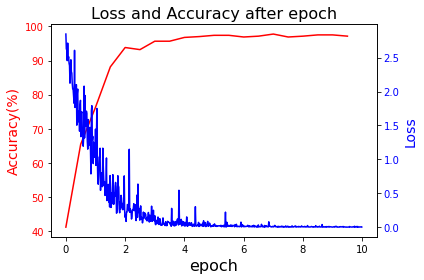

<Figure size 432x288 with 0 Axes>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

Figure_PATH = '/content/drive/MyDrive/我的大數據筆記/Handwriting Recognition/j. fifth dataset/14類(重新打散命名)/loss_figure'

xx1 = list(np.array(list(range(0, len(Accuracy_num))))/(len(Accuracy_num)/epoch1))
xx2 = list(np.array(list(range(0, len(loss_num))))/(len(loss_num)/epoch1))

fig, ax1 = plt.subplots()
plt.title('Loss and Accuracy after epoch',fontsize=16)
plt.xlabel('epoch',fontsize=16)
ax2 = ax1.twinx()
ax1.set_ylabel('Accuracy(%)', color='red',fontsize=14)
ax1.plot(xx1, Accuracy_num, color='red')
ax1.tick_params(axis='y', labelcolor='red')
ax2.set_ylabel('Loss', color='blue',fontsize=14)
ax2.plot(xx2,loss_num,color = 'blue')
ax2.tick_params(axis='y', labelcolor='blue')
fig.tight_layout()
plt.show()
plt.savefig(f'{Figure_PATH}/仲容0829_loss_epoch.png')


# **測試資料 Testing**

In [ ]:
# 在測試資料前，先讀取剛剛存好的模型參數 
# 先前已宣告好PATH變數為模型參數的存放路徑

pretrained_dict = torch.load(PATH)
resnet18_dict = resnet18.state_dict()
resnet18_dict.update(pretrained_dict)
resnet18.load_state_dict(resnet18_dict)
print("Finish loading parameter.")

Finish loading parameter.


This label is a 珮如非本人
Prediction is a 珮如本人
torch.Size([3, 128, 128])


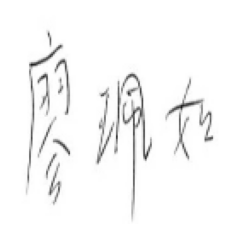

This label is a 仲容非本人
Prediction is a 仲容本人
torch.Size([3, 128, 128])


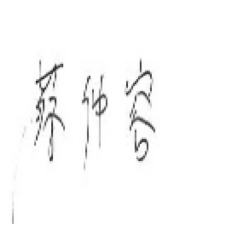

This label is a 佳欣非本人
Prediction is a 佳欣本人
torch.Size([3, 128, 128])


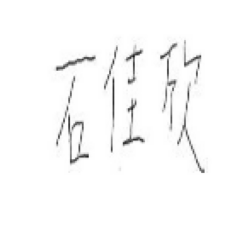

This label is a 明賢本人
Prediction is a 明賢非本人
torch.Size([3, 128, 128])


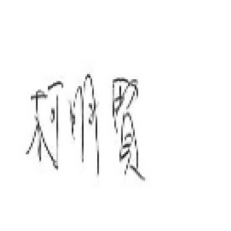

This label is a 珮如非本人
Prediction is a 珮如本人
torch.Size([3, 128, 128])


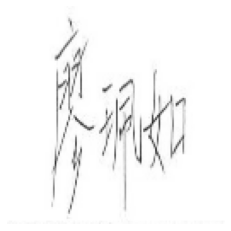

This label is a 佳欣非本人
Prediction is a 佳欣本人
torch.Size([3, 128, 128])


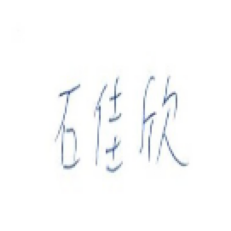

This label is a 仲容本人
Prediction is a 仲容非本人
torch.Size([3, 128, 128])


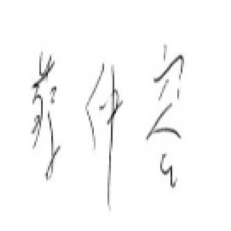

This label is a 珮如本人
Prediction is a 珮如非本人
torch.Size([3, 128, 128])


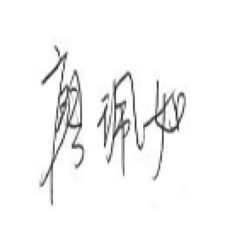

This label is a 珮如非本人
Prediction is a 珮如本人
torch.Size([3, 128, 128])


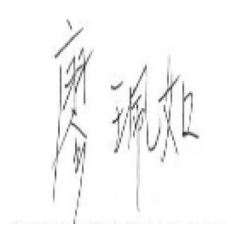

This label is a 佳欣非本人
Prediction is a 佳欣本人
torch.Size([3, 128, 128])


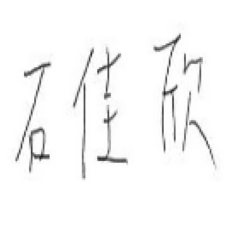

This label is a 佳欣非本人
Prediction is a 佳欣本人
torch.Size([3, 128, 128])


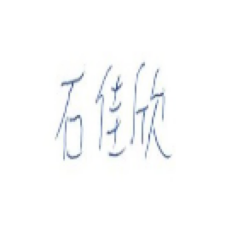

This label is a 珮如非本人
Prediction is a 珮如本人
torch.Size([3, 128, 128])


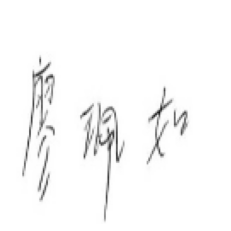

This label is a 珮如本人
Prediction is a 珮如非本人
torch.Size([3, 128, 128])


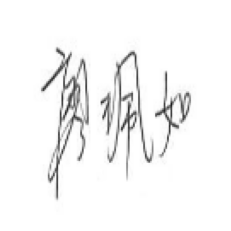

This label is a 仲容本人
Prediction is a 仲容非本人
torch.Size([3, 128, 128])


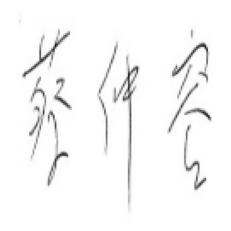

This label is a 珮如本人
Prediction is a 珮如非本人
torch.Size([3, 128, 128])


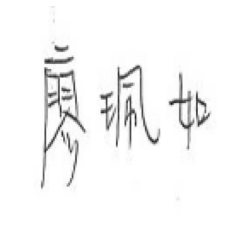

This label is a 仲容非本人
Prediction is a 仲容本人
torch.Size([3, 128, 128])


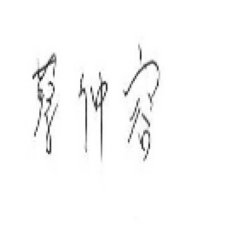

This label is a 明賢非本人
Prediction is a 明賢本人
torch.Size([3, 128, 128])


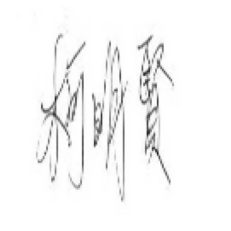

This label is a 仲容本人
Prediction is a 佳欣非本人
torch.Size([3, 128, 128])


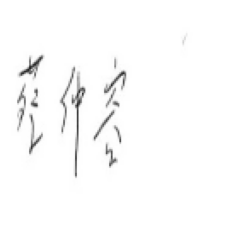

This label is a 旻家非本人
Prediction is a 旻家本人
torch.Size([3, 128, 128])


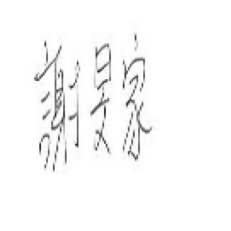

Model accuracy on 810 test images: 97.65%


Category   - Accuracy
others     - 100.0
photos     - 100.0
仲容本人       - 95.0
仲容非本人      - 96.7
佳欣本人       - 100.0
佳欣非本人      - 93.3
旻家本人       - 100.0
旻家非本人      - 98.3
明賢本人       - 98.3
明賢非本人      - 98.3
榮昇本人       - 100.0
榮昇非本人      - 100.0
珮如本人       - 95.0
珮如非本人      - 93.3


In [ ]:
#測試資料 
total_correct = 0
total_images = 0
confusion_matrix = np.zeros([num_classes, num_classes], int)
show_img = True
with torch.no_grad():
  for data in testloader: 
    images, labels = data # images=每張影像的像素(有正規化的)，labels=標籤
    images, labels = images.to(device), labels.to(device) # 將Tensor拷貝至拷貝至GPU上運算
    outputs = resnet18(images)
    _, predicted = torch.max(outputs.data, 1)
    
    # 顯示第一組batch的預測結果
    # if show_img:
    for j in range(len(images)):
      if str(classes[labels[j]])!=str(classes[predicted[j]]):
        print("This label is a "+ str(classes[labels[j]]))
        print("Prediction is a "+ str(classes[predicted[j]]))
        imshow(images[j].cpu())
      # show_img = False


    total_images += labels.size(0)
    total_correct += (predicted == labels).sum().item()
    for i, l in enumerate(labels):
      confusion_matrix[l.item(), predicted[i].item()] += 1

model_accuracy = total_correct / total_images * 100
print('Model accuracy on {0} test images: {1:.2f}%'.format(total_images, model_accuracy))
print("\n")
print('{0:10s} - {1}'.format('Category','Accuracy'))
for i, r in enumerate(confusion_matrix):
    print('{0:10s} - {1:.1f}'.format(classes[i], r[i]/np.sum(r)*100))
    

# **顯示出混淆矩陣 Dispaly Confusion Matrix**

1. 對角線越深越好

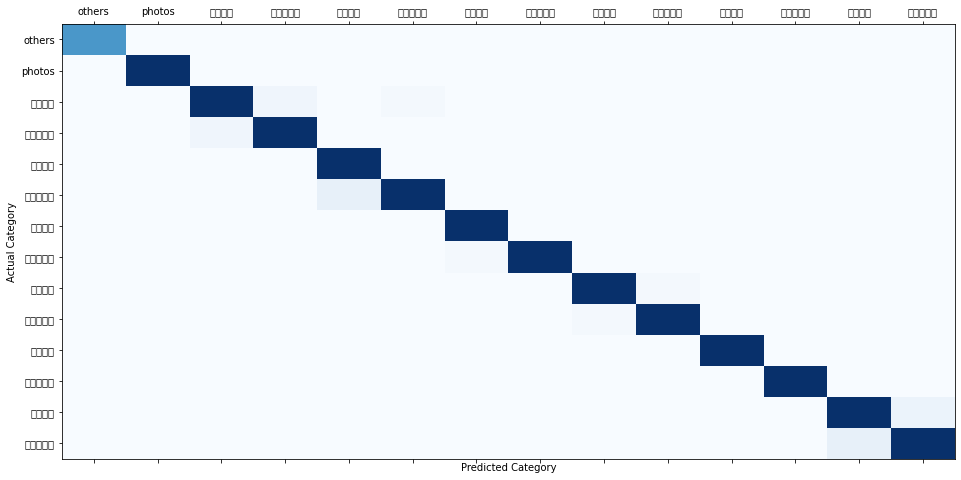

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(16,8))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=50, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(num_classes), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(num_classes), classes)
plt.show()